<a href="https://colab.research.google.com/github/deepakgowtham/EVA4/blob/master/Session15A/Session15A_Mask_RCNN01_dee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import os
from skimage import io
from tqdm import tqdm


In [0]:
!rm -rf /content/Mask_RCNN/*

In [0]:
#copy bg/fg/mask files from Drive
%%bash
cd /content
mkdir Mask_RCNN
cp -r /content/gdrive/My\ Drive/RCNN/* Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/Cars_Mask Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/bg Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/fg_bg Mask_RCNN/
#cp -r /content/gdrive/My\ Drive/resized/fg_bg_mask Mask_RCNN/
ls Mask_RCNN/fg/ |wc -l
ls Mask_RCNN/Cars_Mask/ |wc -l
ls Mask_RCNN/bg/ |wc -l
ls Mask_RCNN/fg_bg/ |wc -l
ls Mask_RCNN/fg_bg_mask/ |wc -l

ls -lrt Mask_RCNN/

104
0
102
0
0
total 20
drwx------ 2 root root 4096 May  9 06:26 bg
drwx------ 2 root root 4096 May  9 06:26 Cars_Mask
drwx------ 2 root root 4096 May  9 06:26 fg
drwx------ 2 root root 4096 May  9 06:26 fg_bg_mask
drwx------ 2 root root 4096 May  9 06:26 fg_bg


mkdir: cannot create directory ‘Mask_RCNN’: File exists


In [0]:
#Function to gegerate Mask
def gen_mask(T, image):
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            image[y, x] = 255 if image[y, x] >= T else 0
            
    # return the thresholded image
    return image

In [0]:
#Generate mask
import os
import numpy as np
import matplotlib.pyplot as plt

path='./Mask_RCNN/fg/'
tgt_path='./Mask_RCNN/Cars_Mask/'
for im_name in os.listdir(path):
    src1 = cv2.imread(path+im_name)
    gray = cv2.cvtColor(src1, cv2.COLOR_BGR2GRAY)
    img=gen_mask(1,gray)
    arr = np.asarray(img)
    cv2.imwrite(tgt_path+im_name, img)

In [0]:
!cp Mask_RCNN/Cars_Mask/* /content/gdrive/My\ Drive/RCNN/Cars_Mask/

In [0]:
## Function to Create Overlay
def overlay_fg_bg(fg,bg,x_offset,y_offset,tgt_save):
    fg_bg=bg.copy()
    y1, y2 = y_offset, y_offset + fg.shape[0]
    x1, x2 = x_offset, x_offset + fg.shape[1]
    
    alpha_fg = fg[:, :, 3] / 255.0
    alpha_bg = 1.0 - alpha_fg

    for c in range(0, 3):
        fg_bg[y1:y2, x1:x2, c] = (alpha_fg * fg[:, :, c] +
                                  alpha_bg * bg[y1:y2, x1:x2, c])


    cv2.imwrite(tgt_save,fg_bg)
    
    #arr = np.asarray(fg_bg)
    #plt.imshow(arr, vmin=0, vmax=255)
    #plt.show()
    
def overlay_mask(fg,bg,x_offset,y_offset,tgt_save):
    fg_bg=bg.copy()
    fg_bg[y_offset:y_offset+fg.shape[0], x_offset:x_offset+fg.shape[1]] = fg


    cv2.imwrite(tgt_save,fg_bg)

In [0]:
%%timeit
#Generate fg_bg and mask with fg Size
tgt_path="./Mask_RCNN/fg_bg/"
mask_tgt_path="./Mask_RCNN/fg_bg_mask/"
bg_path="./Mask_RCNN/bg/"
fg_path="./Mask_RCNN/fg/"
mask_path="./Mask_RCNN/Cars_Mask/"

mask_bg = np.zeros((224,224), np.uint8)

for i_bg in os.listdir(bg_path):
    bg = cv2.imread(bg_path+i_bg)
    bg_name=os.path.splitext(i_bg)[0]
    
    for i_fg in os.listdir(fg_path):
        fg = cv2.imread(fg_path+i_fg, -1)
        fg_name=os.path.splitext(i_fg)[0]
        mask_fg = cv2.imread(mask_path+i_fg, -1)
        fg_flip=cv2.flip(fg,1)
        fg_flip_name=fg_name+'_flip'
        mask_fg_flip=cv2.flip(mask_fg,1)
        for i in range(1,21):
            x_offset=randint(0,64)
            y_offset=randint(0,64)
            #fg on bg
            tgt_save=tgt_path+bg_name+fg_name+'_'+str(i)+'.jpg'
            overlay_fg_bg(fg,bg,x_offset,y_offset,tgt_save)
            
            #mask on black bg
            tgt_save=mask_tgt_path+bg_name+fg_name+'_'+str(i)+'.jpg'
            overlay_mask(mask_fg,mask_bg,x_offset,y_offset,tgt_save)

            #LR Flipped fg on bg
            tgt_save=tgt_path+bg_name+fg_flip_name+'_'+str(i)+'.jpg'
            overlay_fg_bg(fg_flip,bg,x_offset,y_offset,tgt_save)
            
            #LR Flipped mask on black bg
            tgt_save=mask_tgt_path+bg_name+fg_flip_name+'_'+str(i)+'.jpg'
            overlay_mask(mask_fg_flip,mask_bg,x_offset,y_offset,tgt_save)

In [0]:
%%bash
#Check the image counts
cd /content
ls Mask_RCNN/fg/ |wc -l
ls Mask_RCNN/Cars_Mask/ |wc -l
ls Mask_RCNN/bg/ |wc -l
ls Mask_RCNN/fg_bg/ |wc -l
ls Mask_RCNN/fg_bg_mask/ |wc -l
du -sh Mask_RCNN/

104
104
102
424320
424320
11G	Mask_RCNN/


In [0]:
#Zip files to Google Drive
%%bash
zip -r /content/gdrive/My\ Drive/RCNN/fg_bg.zip ./Mask_RCNN/fg_bg
zip -r /content/gdrive/My\ Drive/RCNN/fg_bg_mask.zip ./Mask_RCNN/fg_bg_mask

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
!git clone https://github.com/ialhashim/DenseDepth.git
!wget https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5 -O ./DenseDepth/kitti.h5


Cloning into 'DenseDepth'...
remote: Enumerating objects: 235, done.
remote: Total 235 (delta 0), reused 0 (delta 0), pack-reused 235
Receiving objects: 100% (235/235), 11.80 MiB | 35.42 MiB/s, done.
Resolving deltas: 100% (115/115), done.
--2020-05-09 07:34:54--  https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.41.211
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.41.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897384 (165M) [application/x-www-form-urlencoded]
Saving to: ‘./DenseDepth/kitti.h5’

./DenseDepth/kitti. 100%[===================>] 164.89M  30.3MB/s    in 6.1s    

2020-05-09 07:35:01 (27.1 MB/s) - ‘./DenseDepth/kitti.h5’ saved [172897384/172897384]



In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict, load_images, display_images
from matplotlib import pyplot as plt


# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}
# Load model into GPU / CPU
model = load_model('DenseDepth/kitti.h5', custom_objects=custom_objects, compile=False)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
for idx in tqdm(range(1,25)):
    inputs, file_names = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_'+str(idx)+'fg*.jpg'))
    
    outputs = predict(model, inputs,batch_size=150)
    for i in range(outputs.shape[0]):
        img=cv2.resize(outputs[i],(224,224))*225.0
        img_name=file_names[i].replace('fg_bg', 'Depth_output')
        cv2.imwrite(img_name,img)
    del inputs
    del outputs


100%|██████████| 24/24 [22:47<00:00, 56.99s/it]


In [0]:
for idx in tqdm(range(25,50)):
    inputs, file_names = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_'+str(idx)+'fg*.jpg'))
    
    outputs = predict(model, inputs,batch_size=150)
    for i in range(outputs.shape[0]):
        img=cv2.resize(outputs[i],(224,224))*225.0
        img_name=file_names[i].replace('fg_bg', 'Depth_output')
        cv2.imwrite(img_name,img)
    del inputs
    del outputs


100%|██████████| 25/25 [25:44<00:00, 61.77s/it]


In [0]:
for idx in tqdm(range(50,75)):
    inputs, file_names = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_'+str(idx)+'fg*.jpg'))
    
    outputs = predict(model, inputs,batch_size=150)
    for i in range(outputs.shape[0]):
        img=cv2.resize(outputs[i],(224,224))*225.0
        img_name=file_names[i].replace('fg_bg', 'Depth_output')
        cv2.imwrite(img_name,img)
    del inputs
    del outputs

100%|██████████| 25/25 [27:29<00:00, 65.98s/it]


In [0]:
for idx in tqdm(range(75,100)):
    inputs, file_names = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_'+str(idx)+'fg*.jpg'))
    
    outputs = predict(model, inputs,batch_size=150)
    for i in range(outputs.shape[0]):
        img=cv2.resize(outputs[i],(224,224))*225.0
        img_name=file_names[i].replace('fg_bg', 'Depth_output')
        cv2.imwrite(img_name,img)
    del inputs
    del outputs

100%|██████████| 25/25 [28:55<00:00, 69.40s/it]


In [0]:
for idx in tqdm(range(100,103)):
    inputs, file_names = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_'+str(idx)+'fg*.jpg'))
    
    outputs = predict(model, inputs,batch_size=150)
    for i in range(outputs.shape[0]):
        img=cv2.resize(outputs[i],(224,224))*225.0
        img_name=file_names[i].replace('fg_bg', 'Depth_output')
        cv2.imwrite(img_name,img)
    del inputs
    del outputs

100%|██████████| 3/3 [03:37<00:00, 72.46s/it]


In [0]:
!zip -r /content/gdrive/My\ Drive/RCNN/Depth_output.zip /content/Mask_RCNN/Depth_output

In [0]:
!ls /content/Mask_RCNN/Depth_output |wc -l
!du -sh /content/Mask_RCNN/Depth_output 

411840
1.6G	/content/Mask_RCNN/Depth_output


In [0]:
lis2=os.listdir('/content/Mask_RCNN/fg_bg_mask')
lis2[:6]

['bg_60fg_63_flip_20.jpg',
 'bg_83fg_9_10.jpg',
 'bg_60fg_36_4.jpg',
 'bg_8fg_45_13.jpg',
 'bg_3fg_51_flip_3.jpg',
 'bg_6fg_58_1.jpg']

In [0]:
for i in range(5):
    #cm = plt.get_cmap('plasma')
    img=cv2.resize(outputs[i],(112,112))*255
    print(np.amax(img))
    #im=outputs[i]
    print(img.shape)
    #colored_image = cm(img)
    plt.imshow(img,cmap='gray')
    plt.show()
    cv2.imwrite('/content/bg1_'+str(i+1)+'.png',img)
    img_def=cv2.imread('/content/bg1_'+str(i+1)+'.png')
    print(img_def.shape)

    img_1=cv2.imread('/content/bg1_'+str(i+1)+'.png',cv2.IMREAD_UNCHANGED).astype('float32')
    print(np.amax(img_1))
    print(img_1.shape,cv2.IMREAD_UNCHANGED)
    plt.imshow(img_1)
    plt.show()



In [0]:
#Unzip Files to local
%%bash
unzip -d /content ./Mask_RCNN/fg_bg.zip
unzip -d /content ./Mask_RCNN/fg_bg_mask.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
img_list=os.listdir('/content/Mask_RCNN/fg_bg')
img_list[100]

'bg_8fg_89_flip-12.jpg'

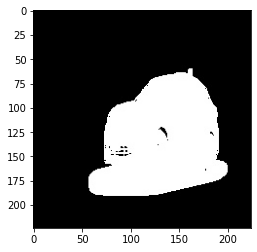

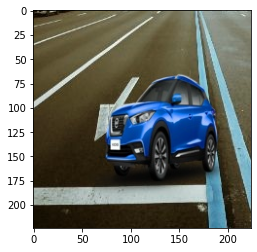

In [0]:
img=cv2.imread('/content/Mask_RCNN/fg_bg_mask/bg_2fg_103_19.jpg')
plt.imshow(img)
#!cv2.imwrite('/content/DenseDepth/test1.jpg',img2)
plt.show()

img=cv2.imread('/content/Mask_RCNN/fg_bg/bg_2fg_103_19.jpg')
plt.imshow(img)
#!cv2.imwrite('/content/DenseDepth/test1.jpg',img2)
plt.show()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

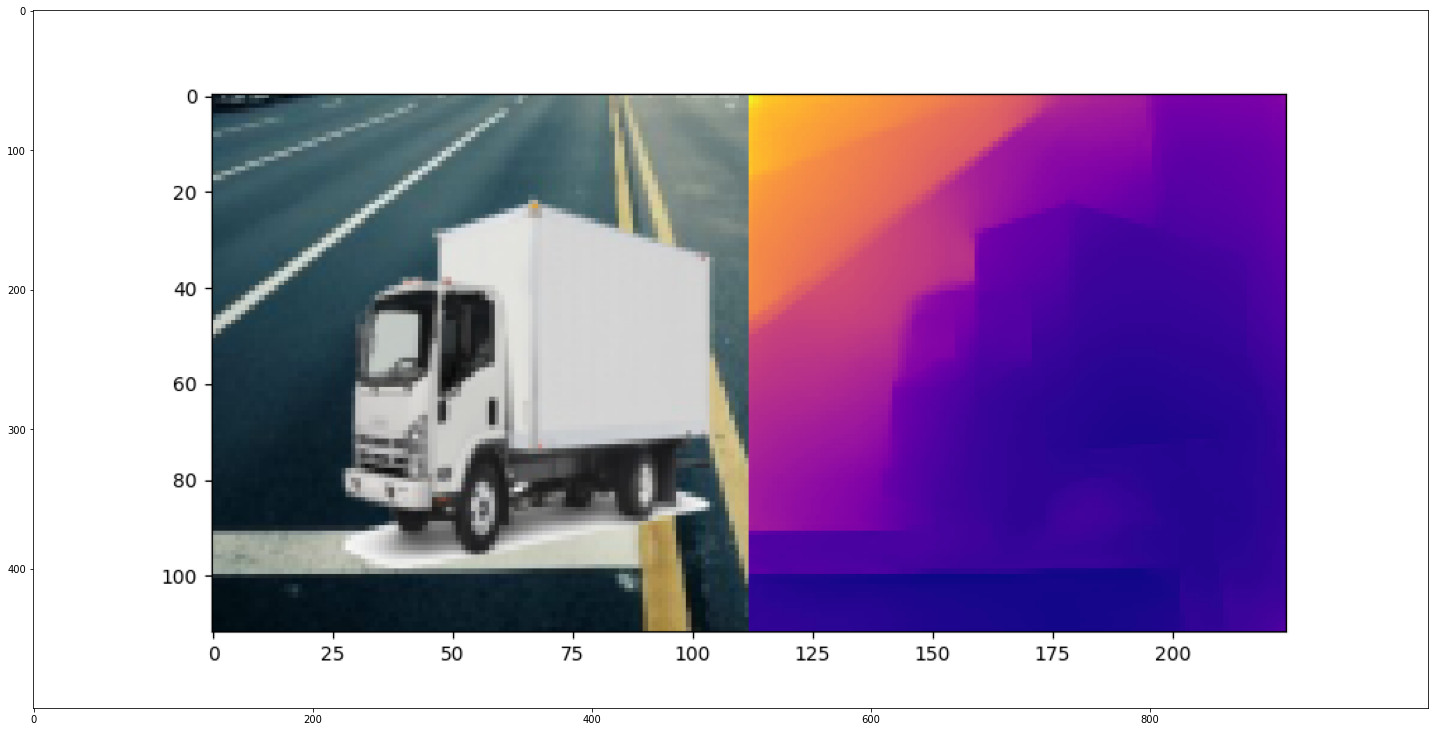

In [0]:
!cd DenseDepth; python test.py --model kitti.h5 --input '/content/Mask_RCNN/fg_bg/bg_2fg_14_19.jpg'
plt.figure(figsize=(25,25))
plt.imshow( io.imread('./DenseDepth/test.png') )

<Figure size 432x288 with 0 Axes>

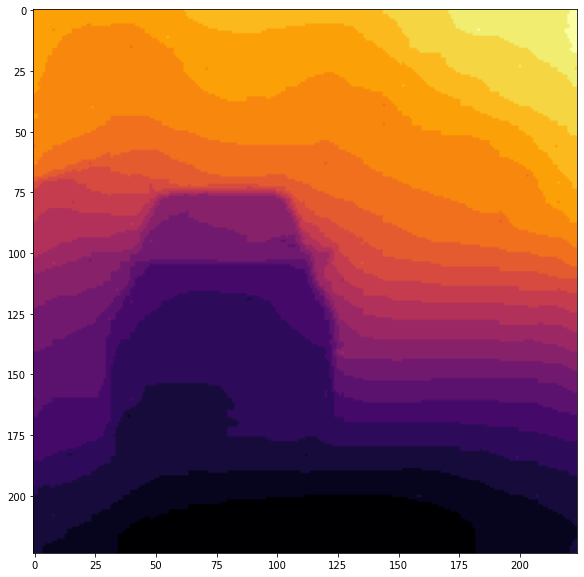

In [0]:
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow( io.imread('/content/Mask_RCNN/Depth_output/bg_1fg_100_1.jpg'),cmap='inferno' )
plt.show()

<Figure size 432x288 with 0 Axes>

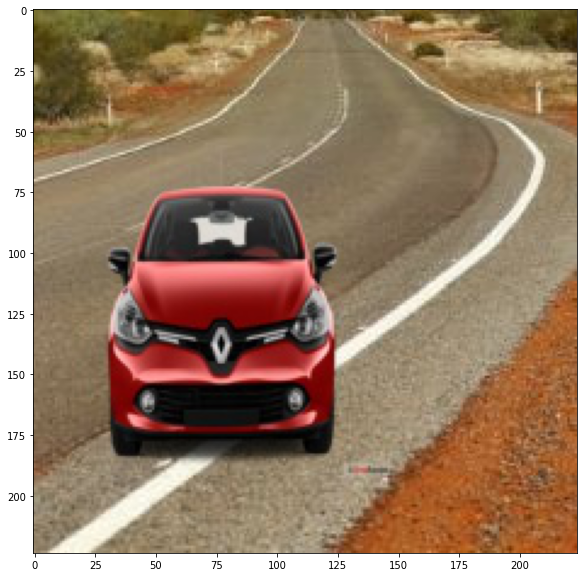

In [0]:
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow( io.imread('/content/Mask_RCNN/fg_bg/bg_1fg_100_1.jpg'), cmap='binary' )
plt.show()

In [0]:
!pip install tensorflow-gpu==1.13.1
!pip install q keras==2.2.4

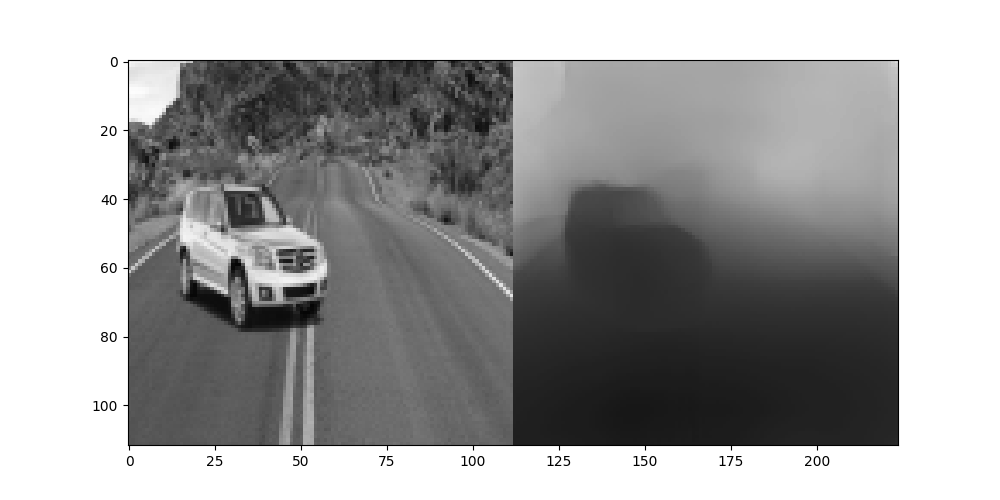

In [0]:
#imgdata = in_zip.read('/content/DenseDepth/test.png')
img = Image.open('/content/DenseDepth/test.png').convert('L')
img

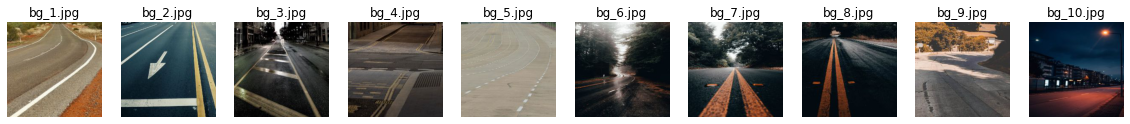

In [0]:
fig= plt.figure(figsize=(20, 30))
for i in range(10):
  ax=fig.add_subplot(1,10, i+1)
  ax.imshow( io.imread(f'/content/Mask_RCNN/bg/bg_{i+1}.jpg') )
  ax.set_title(str(f'bg_{i+1}.jpg'))
  plt.axis('off')
plt.savefig('bg.jpg')
plt.show()

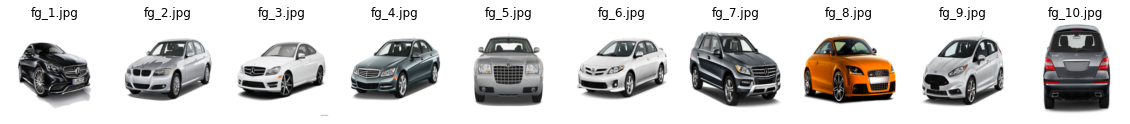

In [0]:
fig= plt.figure(figsize=(20, 30))
for i in range(10):
  ax=fig.add_subplot(1,10, i+1)
  ax.imshow( io.imread(f'/content/Mask_RCNN/fg/fg_{i+1}.png') )
  ax.set_title(str(f'fg_{i+1}.jpg'))
  plt.axis('off')
plt.savefig('fg.jpg')
plt.show()

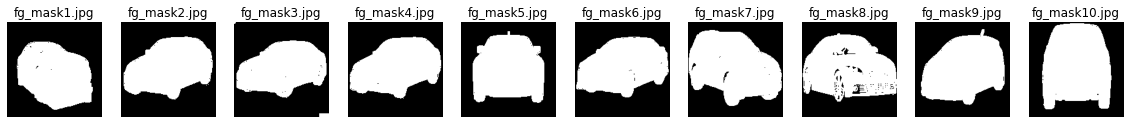

In [0]:
fig= plt.figure(figsize=(20, 30))
for i in range(10):
  ax=fig.add_subplot(1,10, i+1)
  ax.imshow( io.imread(f'/content/Mask_RCNN/Cars_Mask/fg_{i+1}.png'),cmap='gray' )
  ax.set_title(str(f'fg_mask{i+1}.jpg'))
  plt.axis('off')
plt.savefig('fg_mask.jpg')
plt.show()

In [0]:
fg_bg_list=os.listdir('/content/Mask_RCNN/fg_bg')
fg_bg_list[:10]

['bg_60fg_63_flip_20.jpg',
 'bg_83fg_9_10.jpg',
 'bg_60fg_36_4.jpg',
 'bg_8fg_45_13.jpg',
 'bg_3fg_51_flip_3.jpg',
 'bg_6fg_58_1.jpg',
 'bg_43fg_46_3.jpg',
 'bg_78fg_71_8.jpg',
 'bg_60fg_90_17.jpg',
 'bg_84fg_63_2.jpg']

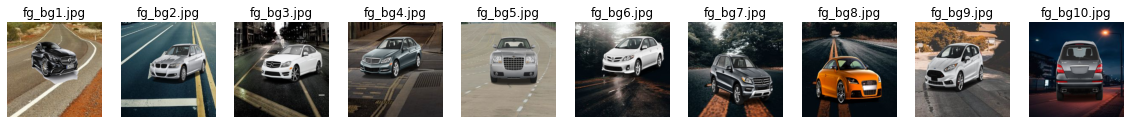

In [0]:
fig= plt.figure(figsize=(20, 30))
for i in range(10):
  ax=fig.add_subplot(1,10, i+1)
  ax.imshow( io.imread(f'/content/Mask_RCNN/fg_bg/bg_{i+1}fg_{i+1}_{i+1}.jpg') )
  ax.set_title(str(f'fg_bg{i+1}.jpg'))
  plt.axis('off')
plt.savefig('fg_bg.jpg')
plt.show()

In [0]:
fg_bg_mask_list=os.listdir('/content/Mask_RCNN/fg_bg_mask')
fg_bg_mask_list[:10]

['bg_60fg_63_flip_20.jpg',
 'bg_83fg_9_10.jpg',
 'bg_60fg_36_4.jpg',
 'bg_8fg_45_13.jpg',
 'bg_3fg_51_flip_3.jpg',
 'bg_6fg_58_1.jpg',
 'bg_43fg_46_3.jpg',
 'bg_78fg_71_8.jpg',
 'bg_60fg_90_17.jpg',
 'bg_84fg_63_2.jpg']

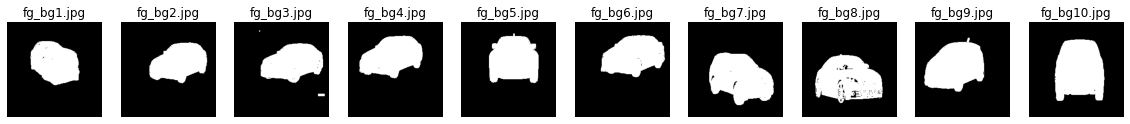

In [0]:
fig= plt.figure(figsize=(20, 30))
for i in range(10):
  ax=fig.add_subplot(1,10, i+1)
  ax.imshow( io.imread(f'/content/Mask_RCNN/fg_bg_mask/bg_{i+1}fg_{i+1}_{i+1}.jpg'),cmap='gray' )
  ax.set_title(str(f'fg_bg{i+1}.jpg'))
  plt.axis('off')
plt.savefig('fg_bg_mask.jpg')
plt.show()

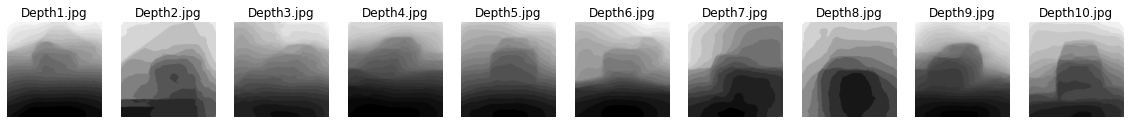

In [0]:
fig= plt.figure(figsize=(20, 30))
for i in range(10):
  ax=fig.add_subplot(1,10, i+1)
  ax.imshow( io.imread(f'/content/Mask_RCNN/Depth_output/bg_{i+1}fg_{i+1}_{i+1}.jpg'), cmap='gray' )
  ax.set_title(str(f'Depth{i+1}.jpg'))
  plt.axis('off')
plt.savefig('Depth.jpg')  
plt.show()

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
for idx in tqdm(range(50,75)):
    inputs, file_names = load_images( glob.glob('/content/Mask_RCNN/fg_bg/bg_'+str(idx)+'fg*.jpg'))
    

In [0]:
!mkdir /content/Mask_RCNN/fg_bg_mask/fg_bg_mask
!mkdir /content/Mask_RCNN/Depth_output/Depth_output

In [0]:
import shutil

source='/content/Mask_RCNN/fg_bg_mask/'
dest1= '/content/Mask_RCNN/fg_bg_mask/fg_bg_mask'
files = os.listdir(source)

for f in tqdm(files):
    shutil.move(source+f, dest1)

100%|██████████| 424321/424321 [00:35<00:00, 11814.61it/s]


In [0]:
len(os.listdir(dest1))

424320

In [0]:
torch.cuda.is_available()

True

In [0]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(root='/content/Mask_RCNN/fg_bg/', transform=transform)


loader = DataLoader(
    dataset,
    batch_size=600,
    num_workers=1,
    shuffle=False,
    pin_memory=True
)


mean = 0.
std = 0.
nb_samples = 0.
for data,_ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

100%|██████████| 708/708 [21:21<00:00,  1.81s/it]


In [0]:
mean, std

(tensor([0.3931, 0.3785, 0.3606]), tensor([0.1965, 0.1813, 0.1779]))

In [0]:
lis1=os.listdir('/content/Mask_RCNN/Depth_output/content/Mask_RCNN/Depth_output')
lis1[:5]

['bg_60fg_63_flip_20.jpg',
 'bg_83fg_9_10.jpg',
 'bg_60fg_36_4.jpg',
 'bg_8fg_45_13.jpg',
 'bg_3fg_51_flip_3.jpg']

In [0]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(root='/content/Mask_RCNN/fg_bg_mask/Mask_RCNN/', transform=transform)


loader = DataLoader(
    dataset,
    batch_size=512,
    num_workers=1,
    shuffle=False,
    pin_memory=True
)


mask_mean = 0.
mask_std = 0.
nb_samples = 0.
for data,_ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mask_mean += data.mean(2).sum(0)
    mask_std += data.std(2).sum(0)
    nb_samples += batch_samples

mask_mean /= nb_samples
mask_std /= nb_samples

mask_mean, mask_std

100%|██████████| 829/829 [11:01<00:00,  1.25it/s]


(tensor([0.1630, 0.1630, 0.1630]), tensor([0.3598, 0.3598, 0.3598]))

In [0]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(root='/content/Mask_RCNN/Depth_output/content/Mask_RCNN', transform=transform)


loader = DataLoader(
    dataset,
    batch_size=512,
    num_workers=1,
    shuffle=False,
    pin_memory=True
)


depth_mean = 0.
depth_std = 0.
nb_samples = 0.
for data,_ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    depth_mean += data.mean(2).sum(0)
    depth_std += data.std(2).sum(0)
    nb_samples += batch_samples

depth_mean /= nb_samples
depth_std /= nb_samples

depth_mean, depth_std

100%|██████████| 829/829 [11:46<00:00,  1.17it/s]


(tensor([0.0878, 0.0878, 0.0878]), tensor([0.0157, 0.0157, 0.0157]))

Mean/STD values for your fg_bg, masks and depth images

In [0]:
from google.colab import files
files.download('example.txt') 

FileNotFoundError: ignored